In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mcmc_samplers import SGHMCSampler,LossModule
from ResForkNet import *
import utils as ut
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from collections import OrderedDict
import matplotlib.pyplot as plt
import hiddenlayer as hl
from IPython.display import display, clear_output
torch.manual_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

plt.style.use('ggplot')

cpu


In [2]:
def PearsonCorr(y1, y2):
    v1 = y1 - torch.mean(y1, axis = 0)
    v2 = y2 - torch.mean(y2, axis = 0)
    return torch.sum(v1 * v2, axis = 0) / (torch.sqrt(torch.sum(v1 ** 2, axis = 0)) * torch.sqrt(torch.sum(v2 ** 2, axis= 0)))

def MSE(y1, y2):
    return torch.mean((y1 - y2)**2, axis=0)

def RMSE(y1,y2):
    return torch.sqrt(MSE(y1,y2))

def MAE(y1, y2):
    return torch.mean(torch.abs(y1-y2), axis = 0)

def MAPE(y1, y2):
    return torch.mean(torch.abs(y1-y2) / y1, axis=0)

def compute_statistics(model, path, test_loader, verbose = True):
    model.load_state_dict(torch.load(path,map_location = torch.device(device)))
    model = model.to(device)
    test_data, test_labels = next(iter(test_loader))
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    
    with torch.no_grad():
        predicted_labels = model(test_data)
    mse = MSE(test_labels, predicted_labels)
    rmse = RMSE(test_labels, predicted_labels)
    mae = MAE(test_labels, predicted_labels)
    mape = MAPE(test_labels, predicted_labels)
    corr = PearsonCorr(test_labels, predicted_labels)
    
    if verbose:
        print("{0:>9}".format("Stocks")+" | ".join(["{0:>9}".format(s) for s in stocks]))
        print("-"*len(stocks)*13)
        print("{0:>9}".format("MSE")+" | ".join(["{0:>9}".format(round(el,2)) for el in mse.tolist()]))
        print("-"*len(stocks)*13)
        print("{0:>9}".format("RMSE")+" | ".join(["{0:>9}".format(round(el,2)) for el in rmse.tolist()]))
        print("-"*len(stocks)*13)
        print("{0:>9}".format("MAE")+" | ".join(["{0:>9}".format(round(el,3)) for el in mae.tolist()]))
        print("-"*len(stocks)*13)
        print("{0:>9}".format("MAPE")+"% | ".join(["{0:>8}".format(round(el*100,2)) for el in mape.tolist()])+"%")
        print("-"*len(stocks)*13)
        print("{0:>9}".format("Corr")+" | ".join(["{0:>9}".format(round(el,3)) for el in corr.tolist()]))
    else: return mse, rmse, mae, mape, corr

In [3]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 7,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, length s)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


In [4]:
compute_statistics(model, "Week/model_60_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.92 |      72.4 |     38.69 |      0.47 |      0.85 |      1.35 |      1.57 |      6.91 |      3.04 |      0.52 |      1.07
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.96 |      8.51 |      6.22 |      0.68 |      0.92 |      1.16 |      1.25 |      2.63 |      1.74 |      0.72 |      1.04
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.697 |     5.038 |     4.504 |      0.54 |     0.712 |     0.863 |     0.984 |     1.717 |     1.288 |     0.572 |      0.81
------------

In [5]:
compute_statistics(model, "Week/model_week_6", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.97 |     71.48 |     48.02 |      0.62 |      1.01 |      1.68 |      1.82 |      6.95 |      3.32 |      0.48 |      0.99
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.99 |      8.45 |      6.93 |      0.79 |       1.0 |       1.3 |      1.35 |      2.64 |      1.82 |      0.69 |      0.99
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     0.73 |     5.371 |     4.823 |     0.615 |     0.757 |     0.949 |      1.02 |     1.733 |     1.347 |     0.546 |     0.788
------------

In [6]:
compute_statistics(model, "Week/model_week_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.93 |     52.67 |     38.11 |      0.55 |      0.98 |       1.5 |      1.51 |      5.75 |      2.95 |      0.46 |      0.93
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.97 |      7.26 |      6.17 |      0.74 |      0.99 |      1.23 |      1.23 |       2.4 |      1.72 |      0.68 |      0.96
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.738 |     4.853 |     4.533 |      0.59 |     0.726 |     0.866 |     0.938 |     1.562 |     1.306 |     0.532 |     0.751
------------

In [12]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 14,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


In [16]:
compute_statistics(model, "2Weeks/model_2week", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE      5.4 |    372.59 |    181.81 |      2.37 |      4.54 |       5.9 |      6.93 |     29.97 |     14.82 |      1.83 |      3.07
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.32 |      19.3 |     13.48 |      1.54 |      2.13 |      2.43 |      2.63 |      5.47 |      3.85 |      1.35 |      1.75
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.774 |    11.418 |     9.327 |      1.18 |     1.628 |     1.774 |     2.001 |     3.561 |     2.948 |     1.086 |     1.369
------------

In [13]:
compute_statistics(model, "2Weeks/model_2week_2", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     3.86 |    248.25 |    135.02 |      1.69 |      3.03 |      4.53 |      5.36 |     19.86 |      10.6 |      1.63 |      2.55
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.96 |     15.76 |     11.62 |       1.3 |      1.74 |      2.13 |      2.32 |      4.46 |      3.26 |      1.28 |       1.6
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.515 |     9.466 |     8.162 |      1.01 |     1.327 |     1.501 |     1.777 |     2.977 |     2.473 |     0.952 |     1.268
------------

In [14]:
compute_statistics(model, "2Weeks/model_2week_3", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     3.31 |    237.52 |    120.53 |      1.39 |      2.66 |       3.7 |      4.84 |     15.29 |      8.94 |      1.11 |       2.3
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.82 |     15.41 |     10.98 |      1.18 |      1.63 |      1.92 |       2.2 |      3.91 |      2.99 |      1.05 |      1.52
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.414 |     9.618 |     7.888 |     0.919 |     1.257 |     1.391 |     1.677 |     2.647 |     2.213 |     0.811 |     1.181
------------

In [17]:
compute_statistics(model, "2Weeks/model_2week_4", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.71 |    172.06 |    112.09 |      1.23 |      2.68 |      3.47 |      4.07 |     15.89 |      7.33 |      1.12 |      1.91
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.65 |     13.12 |     10.59 |      1.11 |      1.64 |      1.86 |      2.02 |      3.99 |      2.71 |      1.06 |      1.38
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.263 |     8.039 |     7.593 |      0.87 |     1.244 |     1.367 |     1.582 |     2.585 |     2.049 |     0.812 |     1.085
------------

In [18]:
compute_statistics(model, "2Weeks/model_2week_5", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.62 |    143.11 |     81.76 |      1.08 |      2.01 |      2.84 |      3.75 |     13.37 |      6.33 |      0.96 |      1.72
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.62 |     11.96 |      9.04 |      1.04 |      1.42 |      1.68 |      1.94 |      3.66 |      2.52 |      0.98 |      1.31
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.251 |     7.661 |     6.398 |     0.799 |     1.093 |     1.233 |     1.473 |     2.332 |     1.886 |      0.78 |     1.022
------------

In [20]:
compute_statistics(model, "2Weeks/model_2week_6", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.34 |    156.78 |     77.27 |      0.89 |       1.8 |      2.51 |       2.9 |     11.51 |      5.82 |      0.78 |      1.48
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.53 |     12.52 |      8.79 |      0.94 |      1.34 |      1.59 |       1.7 |      3.39 |      2.41 |      0.88 |      1.22
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.154 |      7.74 |     6.292 |     0.738 |     1.031 |     1.166 |     1.315 |     2.227 |     1.826 |     0.697 |     0.961
------------

In [21]:
compute_statistics(model, "2Weeks/model_2week_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.03 |    131.51 |      80.7 |      0.87 |      1.65 |      2.88 |      2.75 |     11.76 |      6.46 |       0.8 |      1.48
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.43 |     11.47 |      8.98 |      0.93 |      1.29 |       1.7 |      1.66 |      3.43 |      2.54 |      0.89 |      1.22
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.078 |     7.198 |     6.391 |     0.724 |     0.969 |      1.19 |     1.276 |     2.186 |      1.89 |     0.696 |     0.932
------------

In [22]:
compute_statistics(model, "2Weeks/model_2week_8", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.87 |     91.35 |     59.24 |      0.73 |      1.45 |      2.17 |      2.47 |      7.68 |      4.28 |      0.67 |      1.32
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.37 |      9.56 |       7.7 |      0.85 |      1.21 |      1.47 |      1.57 |      2.77 |      2.07 |      0.82 |      1.15
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.026 |     6.204 |     5.426 |     0.666 |     0.932 |     1.062 |     1.207 |     1.849 |     1.595 |     0.637 |      0.91
------------

In [24]:
compute_statistics(model, "2Weeks/model_2week_9", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.46 |     85.84 |     55.41 |      0.62 |       1.3 |      1.82 |      2.08 |      7.85 |       4.3 |      0.63 |      1.26
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.21 |      9.27 |      7.44 |      0.79 |      1.14 |      1.35 |      1.44 |       2.8 |      2.07 |      0.79 |      1.12
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.924 |     5.822 |     5.168 |     0.621 |     0.875 |     1.013 |     1.115 |     1.841 |     1.535 |     0.608 |     0.876
------------

In [26]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [27]:
compute_statistics(model, "Month/model_month", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     3.71 |     277.3 |    141.77 |      1.98 |      3.42 |      5.98 |       6.1 |     28.68 |     11.33 |      2.27 |      4.29
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.93 |     16.65 |     11.91 |      1.41 |      1.85 |      2.44 |      2.47 |      5.36 |      3.37 |      1.51 |      2.07
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.428 |    10.112 |     8.613 |     1.121 |     1.391 |     1.737 |      1.94 |     3.289 |     2.463 |      1.17 |      1.62
------------

In [29]:
compute_statistics(model, "Month/model_month_2", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.41 |    193.33 |     113.1 |      1.58 |      2.62 |      3.98 |      4.79 |     23.63 |      8.73 |      1.48 |      2.51
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.55 |      13.9 |     10.64 |      1.26 |      1.62 |      1.99 |      2.19 |      4.86 |      2.95 |      1.22 |      1.59
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.182 |     8.331 |     7.378 |     0.985 |     1.247 |     1.464 |     1.762 |     2.921 |      2.23 |     0.953 |     1.216
------------

In [30]:
compute_statistics(model, "Month/model_month_3", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     2.04 |    165.23 |     98.13 |      1.26 |       2.5 |      3.04 |       3.9 |     17.43 |      7.36 |      1.11 |      2.31
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.43 |     12.85 |      9.91 |      1.12 |      1.58 |      1.74 |      1.97 |      4.17 |      2.71 |      1.05 |      1.52
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.082 |     7.961 |     7.083 |     0.874 |     1.228 |     1.241 |     1.561 |      2.58 |     1.952 |     0.835 |     1.177
------------

In [31]:
compute_statistics(model, "Month/model_month_4", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.73 |    123.51 |     98.01 |      1.21 |      1.92 |      2.87 |      3.34 |      12.1 |      7.08 |      1.07 |      1.79
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.31 |     11.11 |       9.9 |       1.1 |      1.39 |      1.69 |      1.83 |      3.48 |      2.66 |      1.03 |      1.34
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.977 |     6.807 |     6.723 |     0.838 |     1.077 |     1.232 |     1.394 |     2.173 |     1.947 |     0.823 |     1.052
------------

In [34]:
compute_statistics(model, "Month/model_month_5", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.67 |    103.24 |     62.62 |      0.97 |      1.56 |       2.4 |      2.67 |     12.96 |      6.15 |      0.92 |      1.59
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.29 |     10.16 |      7.91 |      0.98 |      1.25 |      1.55 |      1.63 |       3.6 |      2.48 |      0.96 |      1.26
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.935 |     6.526 |      5.53 |     0.747 |     0.962 |     1.146 |     1.294 |     2.313 |     1.791 |     0.764 |     0.974
------------

In [35]:
compute_statistics(model, "Month/model_month_6", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.44 |     99.55 |     52.56 |      0.78 |      1.35 |      2.28 |      2.85 |      9.14 |      5.16 |      0.79 |      1.37
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE      1.2 |      9.98 |      7.25 |      0.88 |      1.16 |      1.51 |      1.69 |      3.02 |      2.27 |      0.89 |      1.17
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     0.88 |     6.398 |     5.268 |     0.679 |      0.89 |     1.059 |     1.276 |      1.94 |      1.65 |     0.695 |      0.91
------------

In [37]:
compute_statistics(model, "Month/model_month_7", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.28 |     83.15 |     44.34 |      0.72 |      1.29 |      1.69 |      2.19 |      8.61 |      4.02 |      0.76 |      1.26
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.13 |      9.12 |      6.66 |      0.85 |      1.14 |       1.3 |      1.48 |      2.93 |      2.01 |      0.87 |      1.12
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.833 |     5.499 |     4.911 |     0.669 |     0.867 |      0.96 |     1.162 |     1.969 |     1.459 |     0.676 |     0.871
------------

In [38]:
compute_statistics(model, "Month/model_month_8", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     0.89 |     59.91 |     47.49 |      0.73 |       1.0 |       1.7 |      2.04 |      7.65 |      3.99 |      0.69 |      1.12
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     0.94 |      7.74 |      6.89 |      0.86 |       1.0 |       1.3 |      1.43 |      2.77 |       2.0 |      0.83 |      1.06
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    0.725 |     5.079 |      4.92 |     0.684 |     0.777 |     0.984 |     1.101 |     1.787 |     1.447 |     0.646 |      0.83
------------

In [3]:
transform = ut.ToTensor()
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = 30,transform = transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)
train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=len(test_set),
                        shuffle=False, num_workers=0)

model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2, ll_sizes = [10,100,64])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [4]:
compute_statistics(model, "ReducedMonth/model_reduced_month", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     5.11 |    273.32 |    206.31 |      4.73 |      4.12 |      6.07 |      7.19 |     31.73 |     12.67 |      2.57 |       3.3
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     2.26 |     16.53 |     14.36 |      2.18 |      2.03 |      2.46 |      2.68 |      5.63 |      3.56 |       1.6 |      1.82
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.715 |    11.202 |    10.259 |     1.785 |     1.589 |     1.782 |     2.088 |     3.485 |     2.614 |     1.293 |     1.401
------------

In [5]:
compute_statistics(model, "ReducedMonth/model_reduced_month2", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     3.06 |    158.36 |    106.42 |      1.74 |      2.88 |      3.54 |      4.98 |     23.74 |      8.05 |      2.42 |      2.82
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.75 |     12.58 |     10.32 |      1.32 |       1.7 |      1.88 |      2.23 |      4.87 |      2.84 |      1.55 |      1.68
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE    1.326 |     7.878 |     7.334 |     1.048 |     1.308 |     1.415 |     1.764 |     2.981 |     2.159 |     1.239 |     1.287
------------

In [6]:
compute_statistics(model, "ReducedMonth/model_reduced_month3", test_loader)

   Stocks     AAPL |      AMZN |     GOOGL |       HPQ |      INTC |      MSFT |      NTAP |      NVDA |       SPY |         T |       XRX
-----------------------------------------------------------------------------------------------------------------------------------------------
      MSE     1.86 |    164.36 |    102.63 |      1.06 |      2.31 |      2.83 |      3.77 |     15.84 |      7.98 |      1.65 |      2.67
-----------------------------------------------------------------------------------------------------------------------------------------------
     RMSE     1.36 |     12.82 |     10.13 |      1.03 |      1.52 |      1.68 |      1.94 |      3.98 |      2.83 |      1.29 |      1.64
-----------------------------------------------------------------------------------------------------------------------------------------------
      MAE     1.04 |     7.556 |     6.937 |     0.812 |     1.152 |     1.274 |     1.508 |     2.545 |     2.058 |     1.015 |     1.236
------------

# Statistics

In [56]:
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']
freq = ["Weekly", "Two-Weekly","Monthly"]
metrics = ["MSE", "RMSE", "MAE", "MAPE", "Corr"]
iterables = [stocks, freq]

multi_idx =  pd.MultiIndex.from_product(iterables, names=["stocks", "metrics"])
stats = pd.DataFrame(0,multi_idx, metrics)

In [58]:
for pred_window, f, path in zip([7,14,30],freq,['Week/model_week_7','2Weeks/model_2week_9','Month/model_month_8']):
    torch.manual_seed(torch.initial_seed())
    transform = ut.ToTensor()
    dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = pred_window,transform = transform)
    lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
    train_set, test_set = torch.utils.data.random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                            shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=len(test_set),
                            shuffle=False, num_workers=0)

    model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)
    mse, rmse, mae, mape, corr = compute_statistics(model, path, test_loader, verbose = False)
    mse, rmse, mae, mape, corr = mse.cpu().numpy(), rmse.cpu().numpy(), mae.cpu().numpy(), mape.cpu().numpy(), corr.cpu().numpy()
    stats.loc[pd.IndexSlice[:,f],'MSE'] = mse
    stats.loc[pd.IndexSlice[:,f],'RMSE'] = rmse
    stats.loc[pd.IndexSlice[:,f],'MAE'] = mae
    stats.loc[pd.IndexSlice[:,f],'MAPE'] = mape
    stats.loc[pd.IndexSlice[:,f],'Corr'] = corr

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


In [59]:
stats

MSE      RMSE       MAE      MAPE      Corr
stocks metrics                                                      
AAPL   Weekly       1.004907  1.002451  0.745195  0.062208  0.999312
       Two-Weekly   1.529416  1.236696  0.928687  0.078743  0.998957
       Monthly      0.997556  0.998777  0.757199  0.066729  0.999395
AMZN   Weekly      65.682556  8.104478  5.165511  0.017723  0.999952
       Two-Weekly  86.292091  9.289353  5.818799  0.020167  0.999937
       Monthly     52.187649  7.224102  4.812568  0.018907  0.999963
GOOGL  Weekly      41.450741  6.438225  4.486129  0.009066  0.999884
       Two-Weekly  57.557877  7.586691  5.375896  0.010762  0.999843
       Monthly     45.652702  6.756679  4.898923  0.010187  0.999897
HPQ    Weekly       0.515550  0.718018  0.569963  0.042729  0.985703
       Two-Weekly   0.701212  0.837384  0.657957  0.048691  0.980145
       Monthly      0.750115  0.866092  0.664347  0.047950  0.981144
INTC   Weekly       0.923190  0.960828  0.743332  0.031900  0.997635
       Two-Weekly   1.453491  1.205608  0.936325  0.040311  0.996365
       Monthly      1.090048  1.044054  0.798392  0.034450  0.997315
MSFT   Weekly       1.424277  1.193431  0.865148  0.022727  0.999740
       Two-Weekly   1.932793  1.390249  1.030398  0.026108  0.999664
       Monthly      1.624355  1.274502  0.963935  0.025371  0.999740
NTAP   Weekly       1.662720  1.289465  0.987549  0.031211  0.995680
       Two-Weekly   2.431257  1.559249  1.183006  0.036343  0.993660
       Monthly      1.995071  1.412470  1.097345  0.033970  0.995370
NVDA   Weekly       7.310040  2.703708  1.779342  0.053370  0.999764
       Two-Weekly   9.212213  3.035163  2.013233  0.060053  0.999718
       Monthly      7.342081  2.709627  1.763313  0.060585  0.999785
SPY    Weekly       2.940339  1.714742  1.300439  0.008880  0.999761
       Two-Weekly   4.565568  2.136719  1.537854  0.010280  0.999634
       Monthly      3.729563  1.931208  1.488426  0.009893  0.999734
T      Weekly       0.463270  0.680639  0.533693  0.024958  0.994775
       Two-Weekly   0.660596  0.812770  0.629453  0.029320  0.992702
       Monthly      0.643012  0.801880  0.623067  0.029072  0.992008
XRX    Weekly       0.946041  0.972646  0.735861  0.033634  0.986091
       Two-Weekly   1.198004  1.094533  0.858033  0.038212  0.983468
       Monthly      1.077811  1.038177  0.822348  0.036364  0.984877

# Error Curves

In [5]:
def compute_metrics(model, path, loader, N):
    model.load_state_dict(torch.load(path,map_location = torch.device(device)))
    model = model.to(device)
    
    mse, rmse, = torch.empty((N,1)),torch.empty((N,1))
    mae, mape = torch.empty((N,1)),torch.empty((N,1))
    corr = torch.empty((N,1))
    for idx, (batch_data, batch_labels) in enumerate(loader, 0):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        with torch.no_grad():
            predicted_labels = model(batch_data)
 
        mae = torch.cat([mae,torch.unsqueeze(MAE(batch_labels, predicted_labels),dim=1)],axis=1)
        mape = torch.cat([mape,torch.unsqueeze(MAPE(batch_labels, predicted_labels),dim=1)],axis=1)
        
    return mae, mape

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3837, 60, 330) (3837, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3830, 60, 330) (3830, 11)
torch.Size([1, 3840])


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(3814, 60, 330) (3814, 11)
torch.Size([1, 3840])


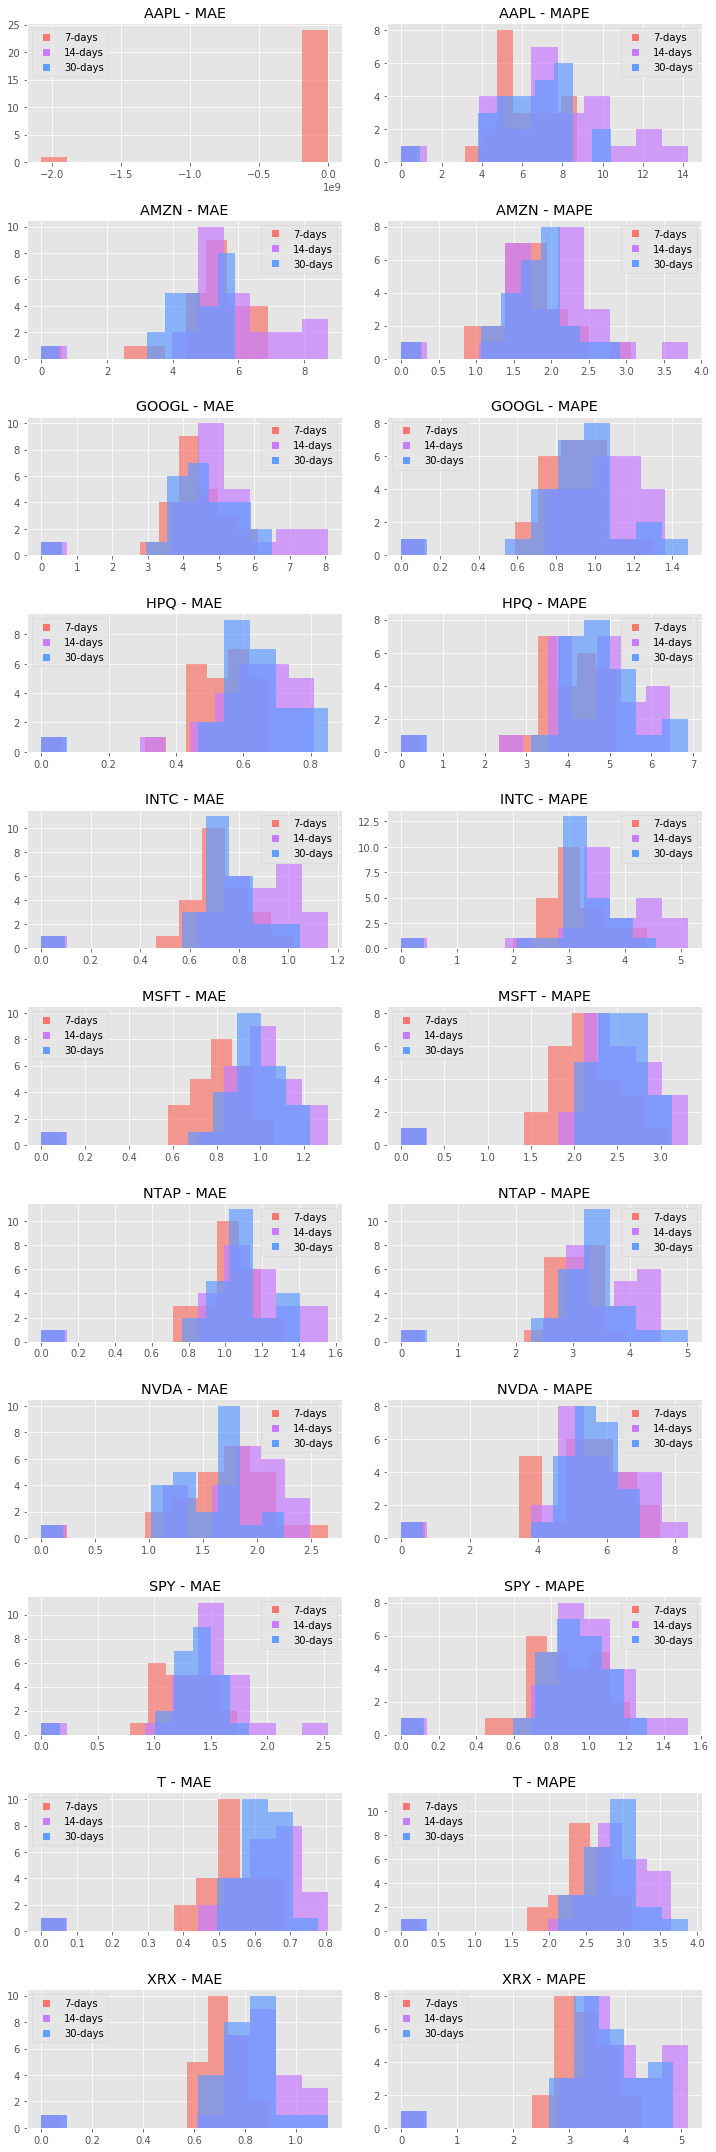

In [12]:
stocks = ['AAPL','AMZN','GOOGL','HPQ','INTC','MSFT','NTAP','NVDA','SPY','T','XRX']

fig, axs = plt.subplots(11,2,figsize=(10,30))
f = lambda ax,m,c: ax.plot([],[],marker=m, color=c, ls="none")[0]
handles = []
for pred_window, path, color in zip([7,14,30],['Week/model_week_7','2Weeks/model_2week_9','Month/model_month_8'],['#F8766D','#C77CFF','#619CFF']):
    torch.manual_seed(torch.initial_seed())
    transform = ut.ToTensor()
    dataset = ut.TechnicalPortfolioTimeSeries(components = stocks, window = 30, pred_window = pred_window,transform = transform)
    lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
    train_set, test_set = torch.utils.data.random_split(dataset, lengths)
    train_loader = DataLoader(train_set, batch_size=128,drop_last = True,
                            shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size= 32,#len(test_set),
                            shuffle=False, num_workers=0)

    model = ResForkNet(n_dependents = len(stocks), num_inputs = 60, timesteps = 30, num_channels = [128]*2)
    #mae_tr, mape_tr = compute_metrics(model, path, train_loader, len(stocks))
    #mae_tr, mape_tr = mae_tr.cpu().numpy(), mape_tr.cpu().numpy()
    
    mae_test, mape_test = compute_metrics(model, path, test_loader, len(stocks))
    mae_test, mape_test = mae_test.cpu().numpy(), mape_test.cpu().numpy()
    
    for i in range(len(stocks)):
        axs[i,0].hist(mae_test[i,:], color = color, bins=len(mae_test), alpha = 0.7)
        axs[i,1].hist(mape_test[i,:]*100, color = color, bins=len(mape_test), alpha = 0.7)
    
    
labels = ['7-days','14-days','30-days']
for i,ax in enumerate(axs):
    handles = [f(ax[0],"s",color) for color in ['#F8766D','#C77CFF','#619CFF']]
    ax[0].legend(handles, labels)
    handles = [f(ax[1],"s",color) for color in ['#F8766D','#C77CFF','#619CFF']]
    ax[1].legend(handles, labels)
    ax[0].set_title("{} - MAE".format(stocks[i]))
    ax[1].set_title("{} - MAPE".format(stocks[i]))
plt.tight_layout()
plt.show()